## Imports

This notebook aims to address the multi-label classification problem around identifying types of fabric in clothing items

pandas - used to interpret dataset and segregate


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
np.random.seed(42)
torch.cuda.set_device(0)
import glob
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Partitioning of data

partitioned the data for the attribute corresponding to fabric

In [ ]:
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('./Eval/list_eval_partition.txt', delim_whitespace=True, header=1)

#creating df of attribute names and type label
attributes = pd.read_csv(
    './Anno/list_attr_cloth.txt', 
    sep='\s{2,}', 
    header=0, 
    skiprows=[0], 
    engine='python')

attributes_imgs = pd.read_csv(
    './Anno/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + attributes['attribute_name'].tolist()))
attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)

#creating df of image names, attribute tags, and dataset label
attributes_df = attributes_imgs.merge(img_partitions, how ='left', on='image_name')

define the training data frame, populate with train and validation data

In [5]:
#create list of column names to keep for training
# 1 = Texture, 2 = Fabric, 3 = Shape, 4 = Parts
list_attr_names = ['image_name']+attributes[(attributes['attribute_type']==2)]['attribute_name'].tolist()
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][list_attr_names].copy()
training_df.reset_index(drop=True, inplace=True)

remove any redundant images from df with no corresponding labels

In [6]:
training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
training_df = training_df[training_df['max'].isin([True])].copy()
training_df.drop('max', axis=1, inplace=True)

In [ ]:
test_df = cleaned_df[cleaned_df['evaluation_status'].isin(['test'])][['image_name','category_name']].copy()
training_df['category_name'].value_counts()
test_df['category_name'].value_counts().plot()

In [7]:
def count_attr_imgs(attr_df):
    col_counts = {}

    for col in attr_df.columns[1:]:
        col_counts[col] = attr_df[col].value_counts().to_frame().loc[True][0]
    
    col_df = pd.DataFrame.from_dict(col_counts, orient='index', columns=['Count'])
    
    return col_df


## data distribution

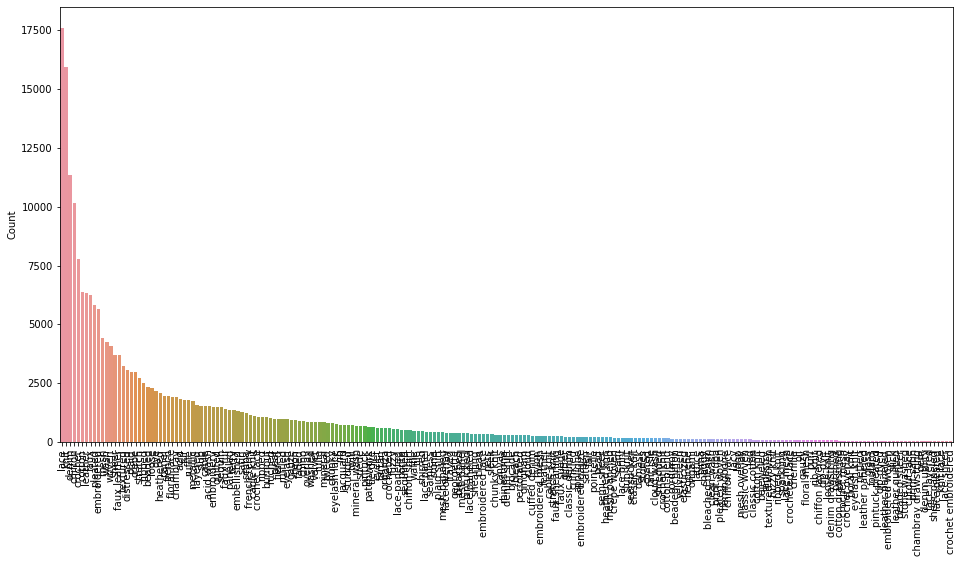

In [8]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False).index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)['Count'])
plt.xticks(rotation=90);

top 25

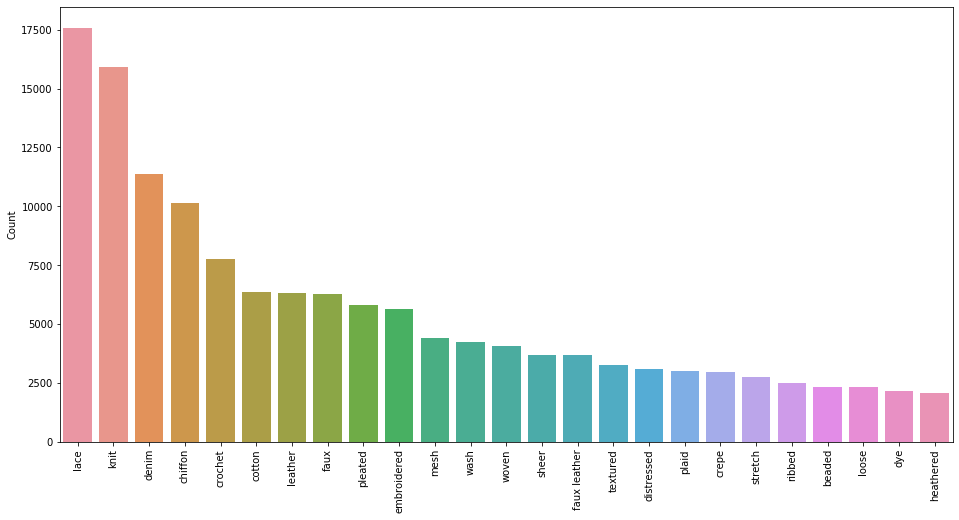

In [9]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25].index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25]['Count'])
plt.xticks(rotation=90);

In [10]:
from fastai import *
from fastai.vision import *

np.random.seed(42)
torch.cuda.set_device(0)

get all columns after the first image_name column  
apply normalisation, set center crop to 150

In [ ]:
label_column_names = training_df.columns.tolist()[1:]
img_base_path = Path("./Img/")
data = ImageDataBunch.from_df(img_base_path, training_df, ds_tfms=get_transforms(), size=224, label_col=label_column_names)
data.normalize(imagenet_stats)

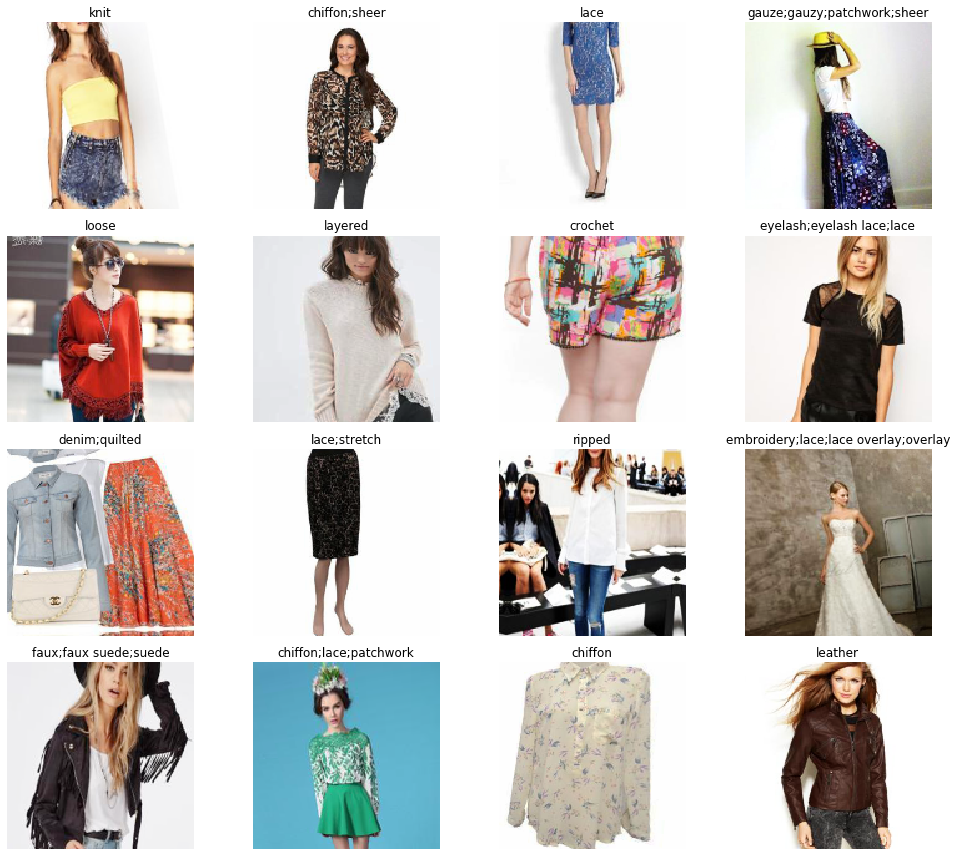

In [11]:
data.show_batch(rows=4, figsize=(14,12))

In [18]:
print(data.classes)
len(data.classes),data.c


['acid', 'acid wash', 'applique', 'bead', 'beaded', 'beaded chiffon', 'beaded sheer', 'bejeweled', 'bleach', 'bleached', 'bleached denim', 'brocade', 'burnout', 'cable', 'cable knit', 'cable-knit', 'canvas', 'chambray', 'chambray drawstring', 'chenille', 'chiffon', 'chiffon lace', 'chiffon layered', 'chiffon shirt', 'chino', 'chunky', 'chunky knit', 'classic cotton', 'classic denim', 'classic knit', 'classic woven', 'clean', 'clean wash', 'cloud', 'cloud wash', 'coated', 'corduroy', 'cotton', 'cotton drawstring', 'cotton knit', 'cotton-blend', 'crepe', 'crepe woven', 'crinkled', 'crochet', 'crochet embroidered', 'crochet knit', 'crochet lace', 'crochet mesh', 'crochet overlay', 'crocheted', 'crocheted lace', 'cuffed denim', 'cutout lace', 'damask', 'denim', 'denim drawstring', 'denim shirt', 'denim utility', 'dip-dye', 'dip-dyed', 'distressed', 'dye', 'elasticized', 'embellished', 'embroidered', 'embroidered gauze', 'embroidered lace', 'embroidered mesh', 'embroidered woven', 'embroide

(218, 218)

In [13]:
acc_03 = partial(accuracy_thresh, thresh=0.3)
f_score = partial(fbeta, thresh=0.3)

In [19]:
learn = cnn_learner(data, models.resnet50, metrics=[acc_03, f_score], callback_fns=ShowGraph, ps=0.2, wd=0.1)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


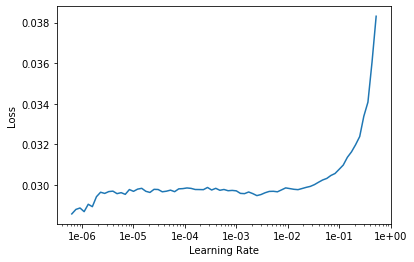

In [17]:
learn.recorder.plot()

In [18]:
learn.unfreeze()

F-Beta Score
F-Beta score is a way of measuring a certain accuracy for a model. It takes into consideration both the Recall and Precision metrics. If you don't know what those are, it's highly recommended to check the previous post about Recall & Precision.

A quick definition of recall and precision, in a non-mathematical way:

Precision: high precision means that an algorithm returned substantially more relevant results than irrelevant ones
Recall: high recall means that an algorithm returned most of the relevant results
So the F-Beta Score is defined as:



When Beta is equal to 1, we have the harmonic mean




epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.030117,0.029215,0.985781,0.354786,10:58
1,0.029110,0.028404,0.986593,0.370197,10:53
2,0.028001,0.027446,0.986621,0.397343,10:49
3,0.026833,0.027177,0.986304,0.405249,10:55


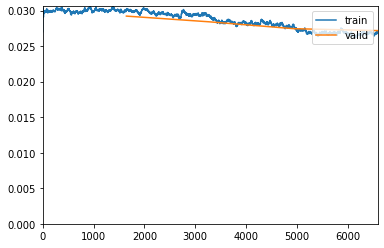

In [19]:
learn.fit_one_cycle(4, slice(1e-5,1e-3))

In [20]:
learn.save('fabric-resnet50-size150-fr5-unfr4', return_path=True)
learn.export('fabric-resnet50-size150-fr5-unfr4.pkl')

In [13]:
learn = load_learner('Img/','fabric-resnet50-size150-fr5-unfr4.pkl')
learn.load

<bound method Learner.load of Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: Img;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: Img;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1)

In [14]:

learn.data = data

In [16]:
def accuracy_topk(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
output, target = learn.get_preds(ds_type=DatasetType.Train)
accuracy_topk(output, target, topk=(3,))

## Utilising test data

In [ ]:
img_base_path = Path("Img/")
testdata = ImageDataBunch.from_df(img_base_path, test_df, ds_tfms=get_transforms(), size=224)
testdata.normalize(imagenet_stats)


learn.data = testdata

output, target = learn.get_preds(ds_type=DatasetType.Train)
top_k_accuracy(output, target, topk=(3,))

output, target = learn.get_preds(ds_type=DatasetType.Train)
top_k_accuracy(output, target, topk=(5,))

# custom images play around

In [18]:
data_classes = ['acid', 'acid wash', 'applique', 'bead', 'beaded', 'beaded chiffon', 'beaded sheer', 'bejeweled', 'bleach', 'bleached', 'bleached denim', 'brocade', 'burnout', 'cable', 'cable knit', 'cable-knit', 'canvas', 'chambray', 'chambray drawstring', 'chenille', 'chiffon', 'chiffon lace', 'chiffon layered', 'chiffon shirt', 'chino', 'chunky', 'chunky knit', 'classic cotton', 'classic denim', 'classic knit', 'classic woven', 'clean', 'clean wash', 'cloud', 'cloud wash', 'coated', 'corduroy', 'cotton', 'cotton drawstring', 'cotton knit', 'cotton-blend', 'crepe', 'crepe woven', 'crinkled', 'crochet', 'crochet embroidered', 'crochet knit', 'crochet lace', 'crochet mesh', 'crochet overlay', 'crocheted', 'crocheted lace', 'cuffed denim', 'cutout lace', 'damask', 'denim', 'denim drawstring', 'denim shirt', 'denim utility', 'dip-dye', 'dip-dyed', 'distressed', 'dye', 'elasticized', 'embellished', 'embroidered', 'embroidered gauze', 'embroidered lace', 'embroidered mesh', 'embroidered woven', 'embroidery', 'eyelash', 'eyelash knit', 'eyelash lace', 'eyelet', 'faded', 'fair', 'fair isle', 'faux', 'faux fur', 'faux leather', 'faux shearling', 'faux suede', 'feather', 'floral knit', 'floral lace', 'floral mesh', 'foulard', 'frayed', 'french', 'french terry', 'fur', 'fuzzy', 'fuzzy knit', 'gauze', 'gauzy', 'gem', 'georgette', 'gingham', 'glass', 'glitter', 'heathered', 'heathered knit', 'herringbone', 'jacquard', 'knit', 'knit lace', 'lace', 'lace layered', 'lace mesh', 'lace overlay', 'lace panel', 'lace paneled', 'lace pleated', 'lace print', 'lace sheer', 'lace-paneled', 'lacy', 'lattice', 'layered', 'leather', 'leather paneled', 'leather quilted', 'leather-paneled', 'led', 'loop', 'loose', 'loose-knit', 'mesh', 'mesh overlay', 'mesh panel', 'mesh paneled', 'mesh-paneled', 'metallic', 'mineral', 'mineral wash', 'neon', 'neoprene', 'nets', 'netted', 'nylon', 'oil', 'organza', 'origami', 'overlay', 'panel', 'paneled', 'patched', 'patchwork', 'perforated', 'pima', 'pintuck', 'pintuck pleated', 'pintucked', 'plaid', 'plaid shirt', 'pleat', 'pleated', 'pleated woven', 'pointelle', 'ponte', 'print satin', 'print scuba', 'purl', 'quilted', 'rhinestone', 'rib', 'rib-knit', 'ribbed', 'ribbed-knit', 'ripped', 'ruched', 'ruffle', 'ruffled', 'sateen', 'satin', 'scuba', 'seam', 'seamless', 'seersucker', 'semi-sheer', 'sequin', 'sequined', 'shaggy', 'shearling', 'sheer', 'sheer-paneled', 'shirred', 'shredded', 'sleek', 'slick', 'slub', 'slub-knit', 'sparkling', 'stone', 'stone washed', 'stones', 'stretch', 'stretch-knit', 'studded', 'suede', 'tapestry', 'tartan', 'terry', 'textured', 'textured woven', 'tie-dye', 'tiered', 'tile', 'tulle', 'tweed', 'twill', 'velvet', 'velveteen', 'waffle', 'wash', 'washed', 'woven']

[('chiffon', 0.1600850522518158), ('velvet', 0.1181684210896492), ('lace', 0.10790783166885376), ('pleated', 0.08976563066244125), ('faux', 0.05630941316485405)]


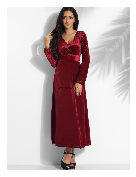

In [23]:
predict_img_path = "data/velvet.jpg" 
category,classIndex,losses = learn.predict(open_image(predict_img_path))
predictions = sorted(zip(data_classes, map(float, losses)), key=lambda p: p[1], reverse=True)
print (predictions[:5])
show_image(open_image(predict_img_path))